In [ ]:
from PIL import Image

img = Image.open("C:\Users\vdubu\OneDrive\Bureau\FISE A3\Stage\Livrables\Résumé\Logo_celia_bleu_sans_slogan_768x471.png")
img.save("C:\Users\vdubu\OneDrive\Bureau\FISE A3\Stage\Livrables\Résumé\Logo_celia_bleu_sans_slogan_768xe471.png", dpi=(300, 300))

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2322162945.py, line 4)

In [ ]:
import numpy as np

dataset_path = "datasets/dataset_light.npy"
loaded_dataset = np.load(dataset_path, allow_pickle=True).item()

print("Loaded dataset keys:")
for key in loaded_dataset.keys():
    print(f"- {key}")

'''print("\nLoaded dataset values:")
for key, value in loaded_dataset.items():
    print(f"- {key}: {value}")'''

# put gain inside a new dictionnary with a key named values
new_dataset = loaded_dataset.copy()
new_dataset["values"] = {"gain": loaded_dataset["gain"]}

# add a new key named name with values from 1 to length of gain
new_dataset["name"] = [str(i) for i in range(len(loaded_dataset["gain"]))]

print("\nNew dataset keys:")
for key in new_dataset.keys():
    print(f"- {key}")

print("\nLength of new dataset data:")
print(f"- {len(new_dataset['data'])}")

# save the new dataset to a file
new_dataset_path = "datasets/dataset_light_correct.npy"
np.save(new_dataset_path, new_dataset, allow_pickle=True)

'''# show the profiles of the new dataset
import matplotlib.pyplot as plt

profiles = new_dataset["data"]
plt.figure(figsize=(10, 6))
for i in range(len(profiles)):
    plt.plot(profiles[i], label=f"Profile {i+1}")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Profiles of the New Dataset")
plt.legend()
plt.grid()
plt.show()'''

In [3]:
# check all itmes in the dataset
import numpy as np

dataset_path = "datasets/db_june_1_small.npy"
loaded_dataset = np.load(dataset_path, allow_pickle=True).item()

print("Loaded dataset keys:")
for key in loaded_dataset.keys():
    print(f"- {key}")

print("\nLoaded dataset values:")
for key in loaded_dataset["values"].keys():
    print(f"- {key}")

print("\nLoaded dataset coil pitch:")
print(f"- {loaded_dataset['data']['pitch'][0]}")

print("\nLoaded dataset time:")
print(f"- {loaded_dataset['time']}")

print("Number of profiles:")
print(f"- {len(loaded_dataset['data']['pitch'])}")

Loaded dataset keys:
- values
- data
- time
- name

Loaded dataset values:
- cutoff
- qsup
- e95
- e99
- coil_E
- Mgain
- gain

Loaded dataset coil pitch:
- [0.00034766 0.00034624 0.0003448  0.00034335 0.00034187 0.00034037
 0.00033886 0.00033734 0.00033581 0.00033427 0.00033274 0.00033121
 0.00032971 0.00032823 0.0003268  0.00032543 0.00032412 0.00032289
 0.00032176 0.00032075 0.00031986 0.00031911 0.00031852 0.00031808
 0.00031782 0.00031773 0.00031782 0.00031808 0.00031852 0.00031912
 0.00031988 0.00032077 0.00032178 0.00032289 0.00032407 0.00032531
 0.00032657 0.00032783 0.00032907 0.00033026 0.00033139 0.00033244
 0.0003334  0.00033425 0.00033499 0.00033563 0.00033618 0.00033663
 0.00033701 0.00033734 0.00033763 0.00033792 0.00033821 0.00033854
 0.00033892 0.00033937 0.00033992 0.00034057 0.00034132 0.00034217
 0.00034313 0.00034419 0.00034533 0.00034653 0.00034779 0.00034907
 0.00035036 0.00035165 0.00035291 0.00035415 0.00035533 0.00035648
 0.00035758 0.00035864 0.00035966 0.000

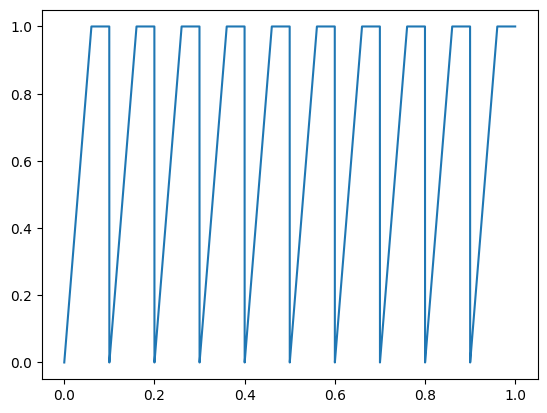

In [8]:
import numpy as np
import matplotlib.pyplot as plt

cycle_length = 500
warmup_length = 300
annealing_coeff = []
x = np.linspace(0, 1, 5000)
for i in range(5000):
    annealing_coeff.append(min(1, i%cycle_length / warmup_length))

plt.plot(x, annealing_coeff)